### Is there a correlation between a movie’s box-office performance and the number of trailer views on YouTube?

In [1]:

import pandas as pd
import pickle
import os
import sys
import warnings
import time

from bs4 import BeautifulSoup
import requests
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36", "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "Accept-Language": "en-US,en;q=0.9", "Referer": "https://www.ewg.org/tapwater/", "Connection": "keep-alive"}

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from xgboost import XGBRegressor
import numpy as np

# scraping

In [ ]:
pages=range(1,101)

all_url_title_dict={}

for page in pages:
    url=f'https://yts.lt/browse-movies/0/all/all/0/downloads/2020-2025/en?page={page}'
    html=requests.get(url, headers=headers).content
    soup=BeautifulSoup(html)
    movies=soup.select('div[class="browse-movie-wrap col-xs-10 col-sm-4 col-md-5 col-lg-4"]')

    url_title_dict={}

    for movie in movies:
        movie_url=movie.select_one('a[class="browse-movie-link"]')['href']
        title=movie.select_one('div[class="browse-movie-bottom"] a[class="browse-movie-title"]').text.replace('\n','')
        release_year=movie.select_one('div[class="browse-movie-bottom"] div[class="browse-movie-year"]').text.replace('\n','')
        movie_title_year=f'{title} ({release_year})'

        url_title_dict[movie_url]=movie_title_year

    all_url_title_dict.update(url_title_dict)

    print(page, end='\r')

In [ ]:
#pickle.dump(all_url_title_dict, open('all_url_title_dict.pickle', 'wb'))
all_url_title_dict=pickle.load( open('all_url_title_dict.pickle', 'rb'))

In [ ]:
title_youtube_dict={}

for i, (movie_url, title) in enumerate(all_url_title_dict.items()):
    try:
        html=requests.get(movie_url, headers=headers).content
        soup=BeautifulSoup(html)
    except:
        continue

    try:
        youtube_link=soup.select_one('a[class="youtube cboxElement"]')['href']
    except:
        youtube_link=None

    title_youtube_dict[title]=youtube_link

    print(f'{i}/{len(all_url_title_dict)}', end='\r')

    

In [ ]:
#pickle.dump(title_youtube_dict, open('title_youtube_dict.pickle', 'wb'))
title_youtube_dict=pickle.load( open('title_youtube_dict.pickle', 'rb'))

In [ ]:
new_title_youtube_dict={}

for title, url in title_youtube_dict.items():
    if url.split('/embed/')[-1].startswith('?rel') or float(title.split(' (')[-1].split(')')[0])<2020:
        continue
    else:
        id=url.split('/embed/')[-1].split('?rel')[0]
        url=f'https://www.youtube.com/watch?v={id}'
        new_title_youtube_dict[title]=url

In [ ]:
boxoffice_dict={}

for year in range(2019, 2026):
    url=f'https://www.boxofficemojo.com/year/{year}/?ref_=bo_lnav_hm_shrt'
    html=requests.get(url, headers=headers).content
    soup=BeautifulSoup(html)

    dict={f'{e.text.strip()} ({year})' : 'https://www.boxofficemojo.com'+e['href'] for e in soup.select('table tr td[class="a-text-left mojo-field-type-release mojo-cell-wide"] a[class="a-link-normal"]:nth-child(1)')}
    boxoffice_dict.update(dict)

    print(f'{year}',end='\r')

In [ ]:
title_youtubelink_boxofficelink_list=[]

for title, youtube_link in new_title_youtube_dict.items():
    if title in boxoffice_dict.keys() or ' '.join(title.split(' ')[:-1]) in boxoffice_dict:
        dict={'Title':title, 
              'Youtube Link':youtube_link, 
              'Boxoffice Link': boxoffice_dict.get(title) or next(k for k in boxoffice_dict if ' '.join(title.split()[:-1]) in k)
              }
        title_youtubelink_boxofficelink_list.append(dict)

In [ ]:
len(title_youtubelink_boxofficelink_list)

In [ ]:
numbers_dict={}

for year in range(2019, 2026):
    url=f'https://www.the-numbers.com/movies/year/{year}'
    html=requests.get(url, headers=headers).content
    soup=BeautifulSoup(html)

    dict={f'{e.text.strip()} ({year})' : 'https://www.the-numbers.com'+e['href'] for e in soup.select('table tr a')}
    numbers_dict.update(dict)

    print(f'{year}',end='\r')
    

new_numbers_dict={}
for title, url in numbers_dict.items():
    if 'on-this-day' in str(url):
        continue
    else:
        new_numbers_dict[title]=url


In [ ]:
title_youtubelink_numberslink_list=[]

for title, youtube_link in new_title_youtube_dict.items():
    if title in numbers_dict.keys() or ' '.join(title.split(' ')[:-1]) in numbers_dict:
        dict={'Title':title, 
              'Youtube Link':youtube_link, 
              'Numbers Link': numbers_dict.get(title) or next(k for k in numbers_dict if ' '.join(title.split()[:-1]) in k)
              }
        title_youtubelink_numberslink_list.append(dict)

In [ ]:
len(title_youtubelink_numberslink_list)

In [ ]:
from selenium import webdriver
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import Select


from selenium.webdriver.edge.options import Options

edge_options = Options()
#edge_options.add_argument('--headless')
edge_options.add_argument("--disable-images")  # Disable images
edge_options.add_argument("--disable-javascript")  # Disable JavaScript
edge_options.add_argument("--disable-plugins")  # Disable plugins
edge_options.add_argument("--disable-extensions")  # Disable extensions
edge_options.add_argument("--blink-settings=imagesEnabled=false")  # Another image disabling flag


# Set a minimal User-Agent (like a text-only browser)
edge_options.add_argument("user-agent=Links (2.25; Linux 2.4.24)")

driver = webdriver.Edge(options=edge_options)
#driver.execute_cdp_cmd("Network.setBlockedURLs", {"urls": ["*.jpg", "*.png", "*.gif","*.svg"]})
#driver.execute_cdp_cmd("Network.enable", {})


driver.maximize_window()

driver.execute_script("document.body.style.zoom='67%'")

In [ ]:
all_data=[]

for i, row in enumerate(title_youtubelink_boxofficelink_list,start=1):

    title=row['Title']
    youtube_link=row['Youtube Link']
    boxoffice_link=row['Boxoffice Link']

    #get youtube data
    driver.get('https://commentviewer.com/')
    try:
        search_bar=driver.find_element(By.CSS_SELECTOR, 'input[id="enterID"]')
        time.sleep(1)
        search_bar.send_keys(youtube_link)
        search_bar.send_keys(Keys.ENTER)
        time.sleep(1)
        info=WebDriverWait(driver,10).until(expected_conditions.visibility_of_element_located((By.CSS_SELECTOR, 'div[class="col-sm"]'))).text
    except:
        info=None
    
    #get boxoffice data
    html=requests.get(boxoffice_link, headers=headers).content
    soup=BeautifulSoup(html)

    try:
        opening_money=[e for e in soup.select('div[class="a-section a-spacing-none mojo-summary-values mojo-hidden-from-mobile"] div[class="a-section a-spacing-none"]') if 'Opening' in e.text][0].get_text(separator='|')
    except:
        opening_money=None

    try:
        release_date=[e for e in soup.select('div[class="a-section a-spacing-none mojo-summary-values mojo-hidden-from-mobile"] div[class="a-section a-spacing-none"]') if 'Release Date' in e.text][0].get_text(separator='|') 
    except:
        release_date=None

    dict={'Title':title, 
          'Youtube Link':youtube_link,
          'Boxoffice Link':boxoffice_link,
          'Youtube Info':info,
          'Opening Week Box Office':opening_money,
          'Release Date':release_date
          }
    
    all_data.append(dict)

    print(f'Progress: {i}/{len(title_youtubelink_boxofficelink_list)}',end='\r')

# cleaning data

In [2]:
#pickle.dump(all_data, open('all_data.pickle', 'wb'))
all_data=pickle.load( open('all_data.pickle', 'rb'))

In [3]:
df=pd.DataFrame(all_data)

In [4]:
df

,Title,Youtube Link,Boxoffice Link,Youtube Info,Opening Week Box Office,Release Date
0,Die My Love (2025),https://www.youtube.com/watch?v=2jzXHW6Qe70,https://www.boxofficemojo.com/release/rl955351...,DIE MY LOVE | Official Trailer | In Theaters N...,"Opening|$2,614,660|1,983\n theaters","Release Date|Nov 7, 2025"
1,Christy (2025),https://www.youtube.com/watch?v=hSHwFDPfeV8,https://www.boxofficemojo.com/release/rl328803...,Christy | Official Trailer | In Theaters Novem...,"Opening|$1,310,888|2,184\n theaters","Release Date|Nov 7, 2025|\n -\n ..."
2,Keeper (2025),https://www.youtube.com/watch?v=i4gV0d5PvKs,https://www.boxofficemojo.com/release/rl343890...,Keeper. Let's go back to when we didn't know a...,"Opening|$2,527,627|1,950\n theaters","Release Date|Nov 14, 2025"
3,In the Heights (2021),https://www.youtube.com/watch?v=lCYrqpng9QA,https://www.boxofficemojo.com/release/rl367450...,In the Heights | Powerful | HBO Max\nHBO Max\n...,"Opening|$11,504,710|3,456\n theaters","Release Date|Jun 11, 2021"
4,The Lost City (2022),https://www.youtube.com/watch?v=5f9VcZqxFO4,https://www.boxofficemojo.com/release/rl795706...,The Lost City | Official Trailer (2022 Movie) ...,"Opening|$30,453,269|4,253\n theaters","Release Date|Mar 25, 2022|\n -\n ..."
...,...,...,...,...,...,...
522,2 Hearts (2020),https://www.youtube.com/watch?v=OjqewZT0r68,https://www.boxofficemojo.com/release/rl428248...,"2 HEARTS Official Trailer (2020) Jacob Elordi,...","Opening|$522,937|1,683\n theaters","Release Date|Oct 16, 2020"
523,Eleanor the Great (2025),https://www.youtube.com/watch?v=wZ6l2ue--KA,https://www.boxofficemojo.com/release/rl134037...,ELEANOR THE GREAT | Official Trailer (2025)\nS...,"Opening|$894,686|892\n theaters","Release Date|Sep 26, 2025"
524,In the Earth (2021),https://www.youtube.com/watch?v=3Lqkfo7IymU,https://www.boxofficemojo.com/release/rl242385...,"IN THE EARTH - Official Trailer\nNEON\n2,358,0...","Opening|$505,723|547\n theaters","Release Date|Apr 16, 2021"
525,The Tiger Rising (2022),https://www.youtube.com/watch?v=uA-bhno_0XI,https://www.boxofficemojo.com/release/rl389477...,The Tiger Rising | Official Trailer | Sky Cine...,"Opening|$364,216|872\n theaters","Release Date|Jan 21, 2022"


In [5]:
df=df.dropna(subset=['Youtube Info', 'Opening Week Box Office', 'Release Date'], how='any')

In [6]:
df['Youtube Video Title']=df['Youtube Info'].apply(lambda x : x.split('\n')[0])
df['Youtube Channel']=df['Youtube Info'].apply(lambda x : x.split('\n')[1])
df['Youtube Views']=df['Youtube Info'].apply(lambda x : x.split('\n')[2].split('views')[0].replace(',','')).apply(pd.to_numeric)
df['Youtube Likes']=df['Youtube Info'].apply(lambda x : x.split('\n')[3].replace(',','')).apply(pd.to_numeric, errors='coerce')
df['Youtube Trailer Release Date']=df['Youtube Info'].apply(lambda x : x.split('\n')[4].split('Published:')[-1].split(',')[0]).apply(pd.to_datetime)
df['Youtube Comments']=df['Youtube Info'].apply(lambda x : x.split('\n')[5].split('comments')[0].replace(',','')).apply(pd.to_numeric,errors='coerce')

In [7]:
df=df.rename(columns={'Release Date' : 'Movie Release Date'})

In [8]:
df['Movie Release Date']=df['Movie Release Date'].apply(lambda x:x.split('Release Date|')[-1].split('|')[0]).apply(pd.to_datetime,errors='coerce')

In [9]:
box_office=df['Opening Week Box Office'].apply(lambda x : x.split('|')[1].replace('$','').replace(',','')).apply(pd.to_numeric)
theaters=df['Opening Week Box Office'].apply(lambda x : x.split('|')[-1].split('\n')[0].replace(',','')).apply(pd.to_numeric,errors='coerce')

df=df.drop(columns='Opening Week Box Office')

df['Opening Week Box Office']=box_office
df['Number of Theaters in Opening Week']=theaters

In [10]:
df=df[df['Youtube Video Title'].str.contains('#2')==False]

In [11]:
df

,Title,Youtube Link,Boxoffice Link,Youtube Info,Movie Release Date,Youtube Video Title,Youtube Channel,Youtube Views,Youtube Likes,Youtube Trailer Release Date,Youtube Comments,Opening Week Box Office,Number of Theaters in Opening Week
0,Die My Love (2025),https://www.youtube.com/watch?v=2jzXHW6Qe70,https://www.boxofficemojo.com/release/rl955351...,DIE MY LOVE | Official Trailer | In Theaters N...,2025-11-07,DIE MY LOVE | Official Trailer | In Theaters N...,MUBI,11323768,18006.0,2025-10-06,765.0,2614660,1983.0
1,Christy (2025),https://www.youtube.com/watch?v=hSHwFDPfeV8,https://www.boxofficemojo.com/release/rl328803...,Christy | Official Trailer | In Theaters Novem...,2025-11-07,Christy | Official Trailer | In Theaters Novem...,Black Bear,7743430,827.0,2025-09-11,171.0,1310888,2184.0
2,Keeper (2025),https://www.youtube.com/watch?v=i4gV0d5PvKs,https://www.boxofficemojo.com/release/rl343890...,Keeper. Let's go back to when we didn't know a...,2025-11-14,Keeper. Let's go back to when we didn't know a...,NEON,4562061,1867.0,2025-11-05,168.0,2527627,1950.0
3,In the Heights (2021),https://www.youtube.com/watch?v=lCYrqpng9QA,https://www.boxofficemojo.com/release/rl367450...,In the Heights | Powerful | HBO Max\nHBO Max\n...,2021-06-11,In the Heights | Powerful | HBO Max,HBO Max,73492,1794.0,2021-03-15,157.0,11504710,3456.0
4,The Lost City (2022),https://www.youtube.com/watch?v=5f9VcZqxFO4,https://www.boxofficemojo.com/release/rl795706...,The Lost City | Official Trailer (2022 Movie) ...,2022-03-25,The Lost City | Official Trailer (2022 Movie) ...,Paramount Pictures,1211907,4297.0,2021-12-16,215.0,30453269,4253.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,2 Hearts (2020),https://www.youtube.com/watch?v=OjqewZT0r68,https://www.boxofficemojo.com/release/rl428248...,"2 HEARTS Official Trailer (2020) Jacob Elordi,...",2020-10-16,"2 HEARTS Official Trailer (2020) Jacob Elordi,...",Royale Movie Trailers,6377961,95369.0,2020-06-26,1144.0,522937,1683.0
523,Eleanor the Great (2025),https://www.youtube.com/watch?v=wZ6l2ue--KA,https://www.boxofficemojo.com/release/rl134037...,ELEANOR THE GREAT | Official Trailer (2025)\nS...,2025-09-26,ELEANOR THE GREAT | Official Trailer (2025),Sony Pictures Classics,2014028,4940.0,2025-08-12,277.0,894686,892.0
524,In the Earth (2021),https://www.youtube.com/watch?v=3Lqkfo7IymU,https://www.boxofficemojo.com/release/rl242385...,"IN THE EARTH - Official Trailer\nNEON\n2,358,0...",2021-04-16,IN THE EARTH - Official Trailer,NEON,2358061,3069.0,2021-03-25,364.0,505723,547.0
525,The Tiger Rising (2022),https://www.youtube.com/watch?v=uA-bhno_0XI,https://www.boxofficemojo.com/release/rl389477...,The Tiger Rising | Official Trailer | Sky Cine...,2022-01-21,The Tiger Rising | Official Trailer | Sky Cine...,Sky TV,54284,162.0,2022-01-28,NaN,364216,872.0


# analyzing data

In [12]:
df.select_dtypes([int,float]).corr()['Opening Week Box Office'].sort_values(ascending=False)

Opening Week Box Office               1.000000
Number of Theaters in Opening Week    0.574371
Youtube Likes                         0.388117
Youtube Comments                      0.348937
Youtube Views                         0.226808
Name: Opening Week Box Office, dtype: float64

In [13]:
df=df[['Title', 'Youtube Views', 'Youtube Likes', 'Youtube Comments', 'Number of Theaters in Opening Week', 'Opening Week Box Office']]
df

,Title,Youtube Views,Youtube Likes,Youtube Comments,Number of Theaters in Opening Week,Opening Week Box Office
0,Die My Love (2025),11323768,18006.0,765.0,1983.0,2614660
1,Christy (2025),7743430,827.0,171.0,2184.0,1310888
2,Keeper (2025),4562061,1867.0,168.0,1950.0,2527627
3,In the Heights (2021),73492,1794.0,157.0,3456.0,11504710
4,The Lost City (2022),1211907,4297.0,215.0,4253.0,30453269
...,...,...,...,...,...,...
522,2 Hearts (2020),6377961,95369.0,1144.0,1683.0,522937
523,Eleanor the Great (2025),2014028,4940.0,277.0,892.0,894686
524,In the Earth (2021),2358061,3069.0,364.0,547.0,505723
525,The Tiger Rising (2022),54284,162.0,NaN,872.0,364216


<Figure size 2000x500 with 0 Axes>

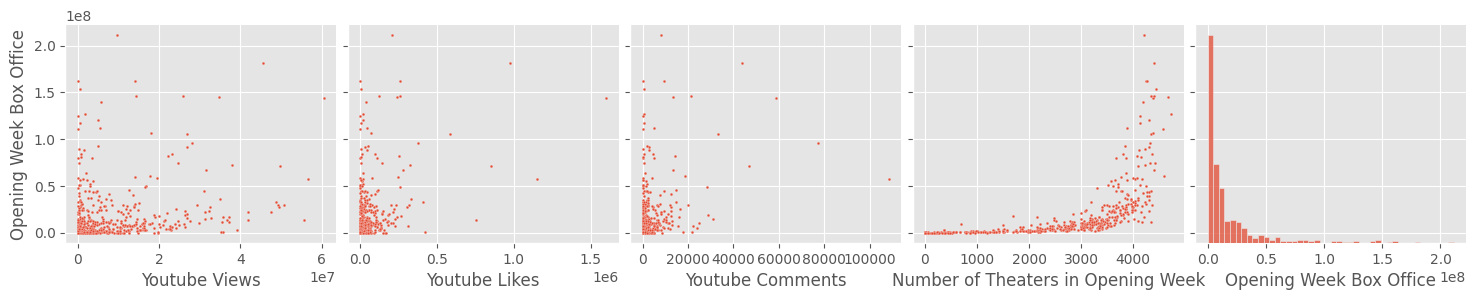

In [16]:
plt.figure(figsize=(20,5))
sns.pairplot(df, y_vars=['Opening Week Box Office'],
             x_vars=df.select_dtypes([int, float]).columns,
             plot_kws={'s': 4},
             height=3)
plt.show()